# Segmentation

In [1]:
from modules import unet,loss_fns,detector
from utils.dataset import PixelSegmentationDataset,VesicleDetectionDataset
from utils.utils import one_hot_encode
import torch
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
from torchvision import transforms
import torch.nn as nn
from PIL import Image

def argmax_to_categorical(preds):
    target = torch.zeros(preds.shape)
    max_indices = torch.argmax(preds, dim=1,keepdim=True).cpu()
    target.scatter_(1, max_indices, 1)
    return target

def make_seg(seg, n_classes=2):
    if n_classes > 2:
        m1 = seg < 8
        m2 = seg > 0
        seg[m1 & m2] = 1
        seg[seg == 8] = 2
    elif n_classes == 2:
        seg = (seg > 0)
    return seg

def load_detector_from_checkpoint(model, checkpoint_path):
    model_dict = torch.load(checkpoint_path)
    model.load_state_dict(model_dict["model"])
    
def load_unet_from_checkpoint(model, checkpoint_path):
    model_dict = torch.load(checkpoint_path)
    model.load_state_dict(model_dict["model"])

def detect(img, model):
    with torch.no_grad():
        img = img.cuda().expand(1, 3, *(img.shape[2:]))
        det_hat = model(img)
    return det_hat
            
def segment(img,model):
    with torch.no_grad():
        img = img.float().cuda()
        seg_hat = model(img).cpu()
    return seg_hat
    

def quantify_class_imbalance(loader, n_classes=2):
    counts = torch.zeros(n_classes)
    for img,seg in tqdm(loader):
        seg = (seg > 0).long()
        cs, vs = torch.unique(seg, return_counts=True)
        counts[cs] += vs
    fig, ax = plt.subplots()
    ax.pie(counts, labels=np.arange(n_classes))
    plt.show()
    return counts

def dice_score(preds, targets):
    #print(preds.shape, targets.shape)
    intersection = torch.einsum('bcij, bcij -> bc', [preds, targets])
    union = torch.einsum('bcij, bcij -> bc', [preds, preds]) + \
            torch.einsum('bcij, bcij -> bc', [targets, targets]) + 1e-16

    iou = torch.div(intersection, union)
    dice = 2*iou
    avg_dice = (torch.einsum('bc->', dice) / (targets.shape[0]*targets.shape[1]))
    return avg_dice

class MyDiceLoss(nn.Module):
    def __init__(self, class_weights=None):
        super(MyDiceLoss, self).__init__()
        self.w = class_weights

    def forward(self, preds, targets):
        intersection = torch.einsum('bcij, bcij -> bc', [preds, targets])
        union = torch.einsum('bcij, bcij -> bc', [preds, preds]) + \
                torch.einsum('bcij, bcij -> bc', [targets, targets])
        
        iou = torch.div(intersection, union)
        dice = torch.div(2*intersection, union)

        avg_dice = (torch.einsum('bc->c', dice) / (targets.shape[0]))
                
        if self.w is not None:    
            avg_dice = torch.dot(self.w, avg_dice)/targets.shape[1]
        else:
            avg_dice = torch.einsum('c->', avg_dice)/targets.shape[1]

        return (1 - avg_dice)

In [19]:
seg_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(0.0),
    transforms.RandomRotation(0),
    transforms.ToTensor()
])

# dataset128 = PixelSegmentationDataset('dataset_p128_d0_vesicle_small', 
#                                        window_size=128, 
#                                        step_size=64, 
#                                        transform=None)

dataset256_mem = PixelSegmentationDataset('dataset_p256_d2_membrane', 
                                       window_size=256, 
                                       step_size=128,  
                                       transform=None)

dataset256_ves = PixelSegmentationDataset('dataset_p256_d2_vesicle_small', 
                                       window_size=256, 
                                       step_size=128, 
                                       transform=None)

dataset256_full = PixelSegmentationDataset('dataset_p256_d5_both', 
                                       window_size=256, 
                                       step_size=128, 
                                       transform=None)

import sklearn.metrics

indices_mem = np.random.permutation(list(range(len(dataset256_mem))))
split_pos_mem = int(0.01 * len(dataset256_mem))

indices_ves = np.random.permutation(list(range(len(dataset256_ves))))
split_pos_ves = int(0.1 * len(dataset256_ves))

indices_full = np.random.permutation(list(range(len(dataset256_full))))
split_pos_full = int(0.01 * len(dataset256_full))

# test_loader256 = torch.utils.data.DataLoader(
#         dataset256_large,
#         batch_size=1,
#         num_workers=4,
#         sampler=None,
#     )

mem_loader = torch.utils.data.DataLoader(
        dataset256_mem,
        batch_size=1,
        num_workers=4,
        sampler=None
#     torch.utils.data.SubsetRandomSampler(indices_mem[:split_pos_mem]),
    )

ves_loader = torch.utils.data.DataLoader(
        dataset256_ves,
        batch_size=1,
        num_workers=4,
        sampler=torch.utils.data.SubsetRandomSampler(indices_ves[:split_pos_ves]),
    )

# test_loader128_lg = torch.utils.data.DataLoader(
#         dataset128_large,
#         batch_size=1,
#         num_workers=4,
#         sampler=torch.utils.data.SubsetRandomSampler(indices128[:split_pos_128]),
#     )

full_loader = torch.utils.data.DataLoader(
        dataset256_full,
        batch_size=1,
        num_workers=4,
        sampler=torch.utils.data.SubsetRandomSampler(indices_full[:split_pos_full]),
    )

Class weights: [9.58854034e-01 8.71944492e-08 4.11458787e-02]
Loaded data in 0.0s
Class weights: [9.54814747e-01 1.37343122e-05 4.32818166e-03 1.94525561e-03
 8.62717023e-05 7.57835734e-04 1.17677988e-03 3.68771939e-02]
Loaded data in 0.0s
Class weights: [9.25486744e-01 1.35748036e-05 3.14088356e-03 2.00895570e-03
 6.05065387e-05 8.31814288e-04 8.44025149e-04 2.83193472e-02
 3.92941487e-02]
Loaded data in 0.0s


## Contour Detection

In [5]:
# Standard imports

def contour_detect(preds, shape=(256,256,3)):
    import cv2
    im_int = np.uint8(preds.cpu().numpy()*255)

    #im_gauss = cv2.GaussianBlur(im_int, (5, 5), 0)
    ret, thresh = cv2.threshold(im_int, 0, 255, 0)
    # get contours
    image, contours, heirarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #out = cv2.drawContours(np.zeros((256,256,3)), contours, -1, (0,255,0), 1)
    out = np.zeros(shape)

    cxs = []
    cys = []
    radii = []
    for c in contours:
        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        rad = np.sqrt(M["m00"]/np.pi)
        if (cX + rad < shape[0]) and (cX - rad >= 0) and (cY + rad <= shape[0]) and (cY - rad) >= 0: 
            # draw the contour and center of the shape on the image
            cv2.circle(out, (cX, cY), 2*int(rad), (255, 0, 0), 2)
            cv2.circle(out, (cX, cY), 1, (255, 0, 0), 1)
            #cv2.drawContours(out, [c], 0, (255,0,0), 2)

            cxs.append(cX)
            cys.append(cY)
            radii.append(2*rad)
    return (out/255.0), cxs, cys, radii

In [6]:
def plot_maps(model, loader, rows, cols, num_classes=2):    
    i = 0
    fig, ax = plt.subplots(rows,cols)
    fig.set_size_inches(4*cols,4*rows)
    avg_rad = []
    avg_dice = 0.0
    for (img,seg) in loader:
        if i == rows*cols:
            break
        seg_hat = segment(img, model)
        seg = make_seg(seg,num_classes).long()
        seg_hot = one_hot_encode(seg, num_classes)
        seg_max = torch.argmax(seg_hat, dim=1)
        #detects,_,_,rads = contour_detect(seg_max[0], shape=(256,256))
        #avg_rad.append(np.mean(rads))
        avg_dice += dice_score(argmax_to_categorical(seg_hat), seg_hot)
        ax[i//cols][i%cols].set_axis_off()
        ax[i//cols][i%cols].imshow(img[0][0].cpu().numpy(), cmap='binary')
        #ax[i//cols][i%cols].imshow(detects,alpha=0.5)
        ax[i//cols][i%cols].imshow(seg_max[0], cmap='Reds', alpha=0.4)
        ax[i//cols][i%cols].imshow(seg[0].cpu().numpy(),cmap='Blues',alpha=0.4)
        i += 1
    #print("Radius: %f"%np.mean(avg_rad))
    print("Average Dice score: %f"%(avg_dice/(rows*cols)))
    return seg_hat

In [7]:
def downstream_dice(model, loader, dim=256):    
    i = 0
    avg_rad = []
    avg_dice = 0.0
    d_dice = 0.0
    t = tqdm(loader)
    print((loader))
    for (img,seg) in t:
        seg_hat = segment(img, model)
        m1 = seg < 8
        m2 = seg > 0
        seg[m1&m2] = 1
        seg[seg == 8] = 2 
        seg = seg.long()
        seg_hot = one_hot_encode(seg, 3)
        seg_max = torch.argmax(seg_hat, dim=1)
        detects,_,_,rads = contour_detect(seg_max[0], shape=(dim,dim))
        detects = torch.Tensor((detects[None,:,:] > 0))
        avg_rad.append(np.mean(rads))
        avg_dice += dice_score(argmax_to_categorical(seg_hat), seg_hot)
        d_dice += dice_score(argmax_to_categorical(seg_hat), one_hot_encode(detects, 2))
        i += 1
        t.set_postfix_str(s='seg dice: %f, down_dice: %f'%(avg_dice/i, d_dice/i))
    print("Radius: %f"%np.mean(avg_rad))
    print("Average Dice score: %f"%(avg_dice/(i)))
    print("Downstream Dice score: %f"%(d_dice/(i)))
    return seg_hat

In [8]:
# model_membrane = unet.UNetAuto(depth=4, n_classes=2)
# load_unet_from_checkpoint(model_membrane, './output/seg/mem_p256_dice_d2/last.checkpoint')
# model_membrane.cuda()

model_both_u4 = unet.FRUNetAuto(depth=4, n_classes=3)
load_unet_from_checkpoint(model_both_u4, './output/seg/fru_p256_d5_u4/last.checkpoint')
model_both_u4.cuda()

model_both_u5 = unet.FRUNetAuto(depth=5, n_classes=3)
load_unet_from_checkpoint(model_both_u5, './output/seg/fru_p256_d5_u5/last.checkpoint')
model_both_u5.cuda()

model_mem = unet.FRUNetAuto(depth=4, n_classes=2)
load_unet_from_checkpoint(model_mem, './output/seg/mem_p256_dice_d2/last.checkpoint')
model_mem.cuda()

model_ves = unet.FRUNetAuto(depth=4, n_classes=2)
load_unet_from_checkpoint(model_ves, './output/seg/ves_p256_dice_d2/last.checkpoint')
model_ves.cuda()

# seg_hat = downstream_dice(model_both, full_loader, 256)

FRUNetAuto(
  (convs): ModuleList(
    (0): FullResBlock(
      (block): Sequential(
        (0): ConvBlock(
          (block): Sequential(
            (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
            (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ResBlock(
          (block): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (2): ConvBlock(
          (block): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
            (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

Average Dice score: 0.719693


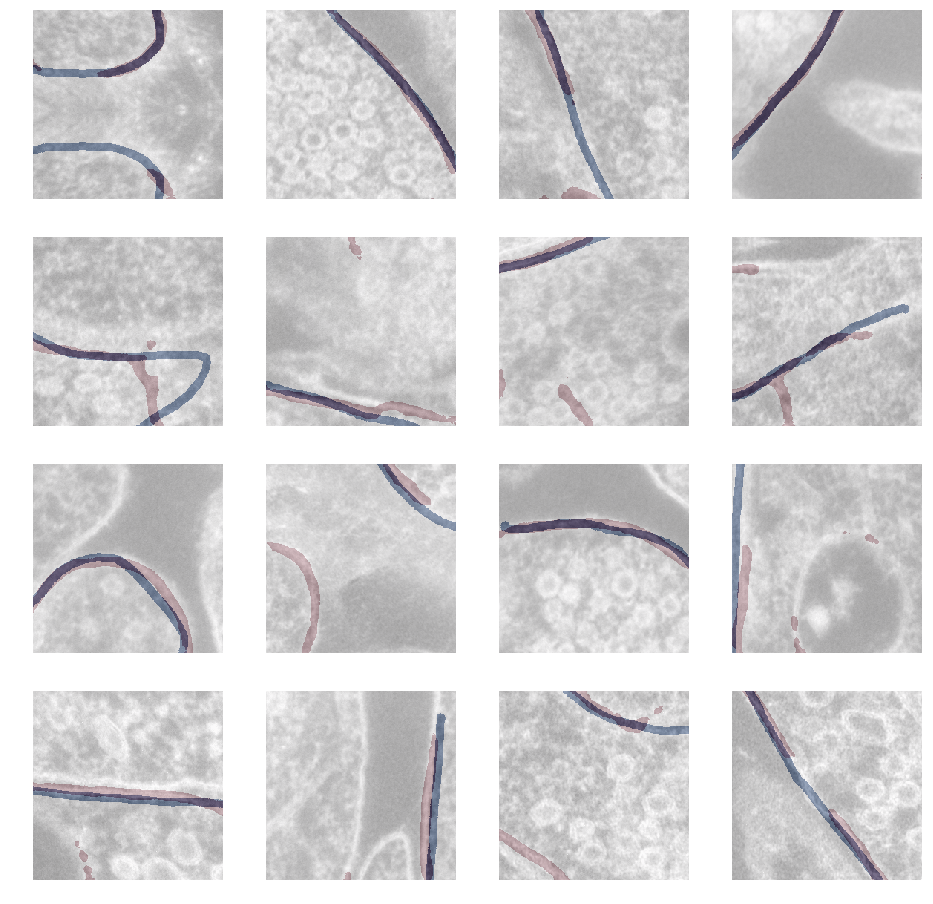

In [15]:
seg_hat = plot_maps(model_mem, mem_loader, 4 ,4, 2)

In [11]:
imgs = iter(test_loader256)
imgsl = iter(test_loader256_lg)

tensor(0.8447)

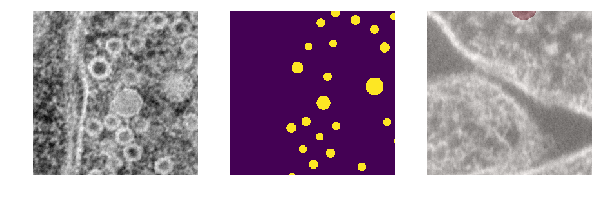

In [20]:
# Get image and seg
img, seg = next(imgs)
imgl, segl = next(imgsl)

seg = (seg > 0).long()
segl = (segl > 0).long()
# Forward pass
seg_hat = segment(img,model_256)
# Compute Dice Loss for eval

seg_max = argmax_to_categorical(seg_hat)
seg_hot = one_hot_encode(seg, 2)

# compute loss
dice_loss = loss_fns.DiceLoss()
loss = dice_loss(seg_hat, seg_hot)

# Plot images
fig,ax = plt.subplots(1,3)

fig.set_size_inches(10,10)
ax[0].set_axis_off()
ax[0].imshow(img[0][0], cmap='binary')

ax[1].set_axis_off()
#ax[1].imshow(img[0][0], cmap='binary')
ax[1].imshow(seg[0])

ax[2].set_axis_off()
ax[2].imshow(imgl[0][0], cmap='binary')
ax[2].imshow(segl[0],cmap='Reds', alpha=0.4)


dice_score(seg_max, seg_hot)

In [ ]:
# detection_dataset = VesicleDetectionDataset('data/vesicle_dataset.pkl', load_from_pickle=True)

In [4]:
indices = np.random.permutation(list(range(len(detection_dataset))))
split_pos = int(0.6 * len(detection_dataset))

det_loader = torch.utils.data.DataLoader(
    detection_dataset,
    batch_size=1,
    num_workers=4,
    sampler=torch.utils.data.SubsetRandomSampler(indices[split_pos:]),
)

In [5]:
det_model = detector.Detector('yolov3/config/yolov3.cfg', detection_dataset.window_size,n_classes=detection_dataset.n_classes)
load_detector_from_checkpoint(det_model, './output/detector/run3/last.checkpoint')
det_model.cuda()

Detector(
  (yolo_net): Darknet(
    (module_list): ModuleList(
      (0): Sequential(
        (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (leaky_0): LeakyReLU(negative_slope=0.1)
      )
      (1): Sequential(
        (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (leaky_1): LeakyReLU(negative_slope=0.1)
      )
      (2): Sequential(
        (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (leaky_2): LeakyReLU(negative_slope=0.1)
      )
      (3): Sequential(
        (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

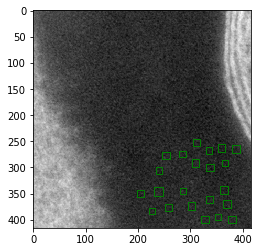

In [22]:
import matplotlib.patches as patches

# Get image and seg
img, det = next(iter(det_loader))

# Ground truth
np_truth_box = det[0, :, 1:].cpu().numpy()
mask = np_truth_box.sum(1) > 0
np_truth_box = np_truth_box[mask]
np_truth_cls = det[0, :, 0].cpu().numpy()[mask]

# Forward pass
pred_boxes, pred_cls = detect(img,det_model)

# Compute Dice Loss for eval

np_pred_box = pred_boxes[0].cpu().numpy()
np_scores = np_pred_box[:, 4]
sort_i = np.argsort(np_scores)
np_pred_box = np_pred_box[sort_i]
np_pred_cls = np.argmax(pred_cls[0].cpu().numpy()[sort_i], axis=1)

# Transform boxes
fig,ax = plt.subplots(1)

ax.imshow(img[0][0], cmap='binary')

for i in range(np_truth_box.shape[0]):
    #x1 ,y1, x2, y2. Get x1,y2,x2-x1,y2-y1
    rect = patches.Rectangle((np_truth_box[i,0], np_truth_box[i,1]),(np_truth_box[i,2] - np_truth_box[i,0]),(np_truth_box[i,3] - np_truth_box[i,1]),linewidth=1,edgecolor='g',fill=False)
    ax.add_patch(rect)

# for i in range(np_pred_box.shape[0]):
#     if np_pred_box[i,4] > 0.8:
#         rect = patches.Rectangle((np_pred_box[i, 0],np_pred_box[i, 1]+np_pred_box[i, 3]),np_pred_box[i, 2],np_pred_box[i, 3],linewidth=1,edgecolor='r',fill=False)
#         ax.add_patch(rect)


# np_pred_box[:, 2] += np_pred_box[:, 0]
# np_pred_box[:, 3] += np_pred_box[:, 1]

In [28]:
loader = torch.utils.data.DataLoader(
        seg_dataset,
        batch_size=1,
        num_workers=4,
    )

In [74]:
def bounding_boxes(preds):
    import cv2
    im_int = np.uint8(preds.cpu().numpy()*255)

    #im_gauss = cv2.GaussianBlur(im_int, (5, 5), 0)
    ret, thresh = cv2.threshold(im_int, 0, 255, 0)
    # get contours
    image, contours, heirarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #out = cv2.drawContours(np.zeros((256,256,3)), contours, -1, (0,255,0), 1)
    out = np.zeros((128,128,3))

    cxs = []
    cys = []
    radii = []
    for c in contours:
        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        area = cv2.contourArea(c)
        rad = int(np.sqrt(4*area/np.pi)/2.0)
        if (cX + 2*rad <= 128) and (cX - 2*rad >= 0) and (cY + 2*rad <= 128) and (cY - 2*rad >= 0): 
            # draw the contour and center of the shape on the image
            cv2.rectangle(out, (cX - 2*rad , cY - 2*rad), (cX + 2*rad , cY + 2*rad) , (0, 255, 0), 1)
            cv2.circle(out, (cX, cY), 1, (255, 0, 0), 1)
            cv2.circle(out, (cX, cY), rad, (0, 0, 255), 1)

            cxs.append(cX-2*rad)
            cys.append(cY-2*rad)
            radii.append(rad)
    
    return (out/255.0), cxs, cys, radii

In [ ]:
it=iter(mem_loader)

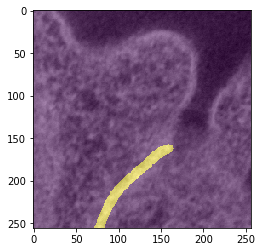

In [22]:
img,seg = next(it)

# create bounding boxes around the segmentation map circles

fig,ax = plt.subplots(1)

ax.imshow(img[0][0],cmap='binary')
ax.imshow(seg[0],alpha=0.5)

In [59]:
seg.shape

torch.Size([1, 128, 128])

In [56]:
import cv2
r,thresh = cv2.threshold(np.uint8(seg.cpu().numpy()*255), 0, 255, 0)

In [58]:
thresh.dtype

dtype('uint8')

In [ ]:
!python main_v0.py --cuda -dp --loss_func=dice -p 256 -s 128 -b 16 -e 30 -r full_p256_dice_d10 -ud 4 -nc 3 --data_path=dataset_p256_d10_both



Using run_code: full_p256_dice_d10
main: Creating dataset
Class weights: [8.88374296e-01 2.56807926e-05 7.59624260e-03 3.55450985e-03
 4.10286022e-05 1.52617564e-03 1.24976340e-03 5.57700135e-02
 4.18622900e-02]
Loaded data in 0.0s
main: Creating train loader
main: Creating test loader
Getting Class balances... 
Class balance: None
train: Beginning train
Starting epoch 0
100%|█████████| 203/203 [01:16<00:00,  2.67it/s, loss: 0.398124, dice: 0.550682]
#### [76.09] Epoch 0 ####
#### loss: 0.487213666215906
#### dice: 0.43782392144203186
#####################
train: Beginning test
100%|███████████████████████████| 87/87 [00:27<00:00,  3.15it/s, loss: 0.414459]
#### Test Dataset, Epoch 0 evaluation ####
#### loss = 0.38106658266878674
#### dice = 0.5731220841407776
##########################################
Saving model to ./output/seg/full_p256_dice_d10/last.checkpoint
Starting epoch 1
100%|█████████| 203/203 [01:03<00:00,  3.22it/s, loss: 0.380098, dice: 0.585984]
#### [63.14] Epoch 1 ##